In [16]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import sys
from matplotlib.colors import ListedColormap, BoundaryNorm
import matplotlib.patches as mpatches
import util

Case = 'NorthDakota'


yt = 2022

crop = 'Potatoes'

filtering = True

width = 1.5

In [17]:
def allpreprocess(timelog,crop=None, filtering=None, width=1.5):
    '''
    Create doy column
    if crop is true subset cases by crop, 
    if filtering is true remove multiple crop cases, filter outlier cases by IQE +/- width*IQR and remove incomplete cases
    '''
    timelog['DayOfYear'] = timelog['Timestamp'].dt.dayofyear
    
    #subset crop
    if crop:
        timelog=timelog[timelog['Crop'] == crop]
    if filtering:
        def filterdf(df, width):
            q_1 = df['DayOfYear'].quantile(0.25)
            q_3  = df['DayOfYear'].quantile(0.75)
            q_low = q_1 - width*(q_3-q_1)
            q_hi  = q_3 + width*(q_3-q_1)

            df_filtered = df[(df['DayOfYear'] < q_hi) & (df['DayOfYear'] > q_low)]
            return df_filtered 
        #Remove multiple crop cases
        timelog=timelog[timelog['Multiple_crop'] == 0]
        filter_temp=[]
        for i,e in enumerate(['First Snow Previous','Last Snow','Emergence','Maturity','Senescence','Dormancy','First Snow']):
            temp_df=timelog[timelog['Activity'] == e].copy()
            #temp_df=filterdf(temp_df, width)
            filter_temp.append(temp_df)
        filtered_timelog=pd.concat(filter_temp)
        ucid,counts=np.unique(filtered_timelog['CaseID'], return_counts=True)
        filter_case=[counts[np.where(ucid==cid)[0][0]] for cid in filtered_timelog['CaseID']]
        filtered_timelog['filter_case']=filter_case
        filtered_timelog=filtered_timelog[filtered_timelog['filter_case'] == 7]
        double_id=[]
        for e in ['First Snow Previous','Last Snow','Emergence','Maturity','Senescence','Dormancy','First Snow']:
            artifact_idx=np.where(np.unique(filtered_timelog[filtered_timelog['Activity'] == e]['CaseID'], return_counts=True)[1]>1)[0]
            for j in artifact_idx:
                double_id.append(np.unique(filtered_timelog[filtered_timelog['Activity'] == e]['CaseID'])[j])
        for id in double_id:
            filtered_timelog=filtered_timelog[filtered_timelog['CaseID'] != id]
        return filtered_timelog
    else:
        return timelog

In [18]:
sites_pth = 'C:/Users/Vito/Documents/Seed_to_harvest_process_monitoring/Source/Data/'+Case+'/sites/'
site_names = os.listdir(sites_pth)
num_sites=len(site_names)

timelog=pd.read_hdf('C:/Users/Vito/Documents/Seed_to_harvest_process_monitoring/Event_log/log_'+Case+'_180724_ALL_df.h5')
words_to_remove = r'\b(Late|Usual|Early)\b\s*'
timelog['Activity'] = timelog['Activity'].str.replace(words_to_remove, '', regex=True)
timelog=allpreprocess(timelog, crop, filtering, width)

In [19]:
timelog

,Activity,Timestamp,Time_uncertainty,Uncertainty_wdith,CaseID,Crop,SiteID,WGS84_lon_lat,County,State,Country,NDVI_range,num_valid_est,Multiple_crop,DayOfYear,filter_case
63,First Snow Previous,2016-12-10,2016-12-10 00:00:00,0,North Dakota_0000_2017,Potatoes,0,"[-97.7912508533528, 48.48155214076392]",Walsh County,North Dakota,United States,"[0.17911939571490929, 0.17911939571490929]",1,0,345,7
77,First Snow Previous,2018-10-12,2018-10-12 00:00:00,0,North Dakota_0000_2019,Potatoes,0,"[-97.7912508533528, 48.48155214076392]",Walsh County,North Dakota,United States,"[0.3146591518720088, 0.3146591518720088]",1,0,285,7
98,First Snow Previous,2021-11-17,2021-11-17 00:00:00,0,North Dakota_0000_2022,Potatoes,0,"[-97.7912508533528, 48.48155214076392]",Walsh County,North Dakota,United States,"[0.22366579138226403, 0.22366579138226403]",1,0,321,7
182,First Snow Previous,2018-10-12,2018-10-12 00:00:00,0,North Dakota_0001_2019,Potatoes,1,"[-97.80065931321923, 48.481753667501835]",Walsh County,North Dakota,United States,"[0.32038830726688355, 0.32038830726688355]",1,0,285,7
203,First Snow Previous,2021-11-17,2021-11-17 00:00:00,0,North Dakota_0001_2022,Potatoes,1,"[-97.80065931321923, 48.481753667501835]",Walsh County,North Dakota,United States,"[0.18865209850460343, 0.18865209850460343]",1,0,321,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20740,First Snow,2019-11-22,2019-11-22 00:00:00,0,North Dakota_0197_2019,Potatoes,197,"[-97.37451675821572, 48.56091828801988]",Pembina County,North Dakota,United States,"[0.05594638944876304, 0.05594638944876304]",1,0,326,7
20761,First Snow,2022-11-20,2022-11-20 00:00:00,0,North Dakota_0197_2022,Potatoes,197,"[-97.37451675821572, 48.56091828801988]",Pembina County,North Dakota,United States,"[0.001752116853936836, 0.001752116853936836]",1,0,324,7
20789,First Snow,2011-11-16,2011-11-16 00:00:00,0,North Dakota_0198_2011,Potatoes,198,"[-97.31581021154727, 48.466473995184366]",Walsh County,North Dakota,United States,"[0.2187071779988971, 0.2187071779988971]",1,0,320,7
20824,First Snow,2016-11-21,2016-11-21 00:00:00,0,North Dakota_0198_2016,Potatoes,198,"[-97.31581021154727, 48.466473995184366]",Walsh County,North Dakota,United States,"[0.2559502019175287, 0.2559502019175287]",1,0,326,7


In [20]:
timelog['year']=timelog['CaseID'].apply(lambda x: x[-4:])
timelog=timelog[timelog['year']==str(yt)]

ls_timelog=timelog[(timelog['Activity'] == 'Last Snow')]
emg_timelog=timelog[(timelog['Activity'] == 'Emergence')]
mat_timelog=timelog[(timelog['Activity'] == 'Maturity')]
sen_timelog=timelog[(timelog['Activity'] == 'Senescence')]
dor_timelog=timelog[(timelog['Activity'] == 'Dormancy')]
fs_timelog=timelog[(timelog['Activity'] == 'First Snow')]

In [35]:
num_sites=len(np.unique(timelog['CaseID']))

In [41]:
progress_array = np.zeros((7,365))
progress_array[0]+=num_sites

for i in range(365):
    #get the new stage of the day
    new_ls=len(ls_timelog[(ls_timelog['DayOfYear'] == i)])
    new_emg=len(emg_timelog[(emg_timelog['DayOfYear'] == i)])
    new_mat=len(mat_timelog[(mat_timelog['DayOfYear'] == i)])
    new_sen=len(sen_timelog[(sen_timelog['DayOfYear'] == i)])
    new_dor=len(dor_timelog[(dor_timelog['DayOfYear'] == i)])
    new_fs=len(fs_timelog[(fs_timelog['DayOfYear'] == i)])
    #update the progress array
    progress_array[0][i]=progress_array[0][i-1]-new_ls
    progress_array[1][i]=progress_array[1][i-1]+new_ls-new_emg
    progress_array[2][i]=progress_array[2][i-1]+new_emg-new_mat
    progress_array[3][i]=progress_array[3][i-1]+new_mat-new_sen
    progress_array[4][i]=progress_array[4][i-1]+new_sen-new_dor
    progress_array[5][i]=progress_array[5][i-1]+new_dor-new_fs
    progress_array[6][i]=progress_array[6][i-1]+new_fs

plot_array = np.zeros((num_sites,365))
for i in range(365):
    marker=int(progress_array[0][i])
    plot_array[:marker,i]=1
    plot_array[marker:marker+int(progress_array[1][i]),i]=2
    marker+=int(progress_array[1][i])
    plot_array[marker:marker+int(progress_array[2][i]),i]=3
    marker+=int(progress_array[2][i])
    plot_array[marker:marker+int(progress_array[3][i]),i]=4
    marker+=int(progress_array[3][i])
    plot_array[marker:marker+int(progress_array[4][i]),i]=5
    marker+=int(progress_array[4][i])
    plot_array[marker:marker+int(progress_array[5][i]),i]=6
    marker+=int(progress_array[5][i])
    plot_array[marker:marker+int(progress_array[6][i]),i]=7


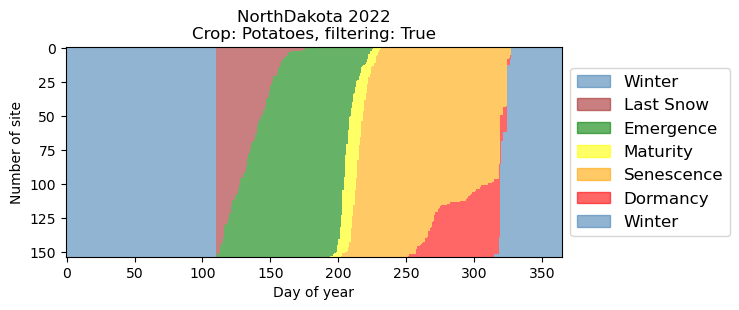

In [42]:

cmap = ListedColormap(['steelblue','brown', 'green', 'yellow', 'orange', 'red','steelblue'])
bounds = [0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5]
norm = BoundaryNorm(bounds, cmap.N)

plt.imshow(plot_array, cmap=cmap, norm=norm, origin='upper',alpha=0.6)
plt.xlabel('Day of year')
plt.ylabel('Number of site')

colors = ['steelblue','brown', 'green', 'yellow', 'orange', 'red','steelblue']
labels = ['Winter', 'Last Snow', 'Emergence', 'Maturity', 'Senescence', 'Dormancy', 'Winter']
patches = [mpatches.Patch(color=color, alpha=0.6, label=label) for color, label in zip(colors, labels)]


plt.legend(handles=patches, fontsize='large', loc='center left', bbox_to_anchor=(1, 0.5))
plt.title(Case+f' {yt}\nCrop: {crop}, filtering: {filtering}')
plt.show()